In [16]:
from cospar import reader, F, paramkeys, datakeys

from functools import reduce
import operator
import math

import numpy as np
from matplotlib.pyplot import get_cmap

from everest.window import Canvas
from everest.window.data import Data
from everest.analysis import time_smooth
%matplotlib inline

In [46]:
datakeys

('t',
 'dt',
 'Nu',
 'Nu_freq',
 'Nu_min',
 'Nu_range',
 'VRMS',
 'strainRate_outer_av',
 'strainRate_outer_min',
 'strainRate_outer_range',
 'stressAng_outer_av',
 'stressAng_outer_min',
 'stressAng_outer_range',
 'stressRad_outer_av',
 'stressRad_outer_min',
 'stressRad_outer_range',
 'temp_av',
 'temp_min',
 'temp_range',
 'velAng_outer_av',
 'velAng_outer_min',
 'velAng_outer_range',
 'velMag_range',
 'visc_av',
 'visc_min',
 'visc_range',
 'yieldFrac')

In [48]:
cut = reader[reduce(operator.__and__, (
    F('f') == 1,
    F('aspect') == 1,
    F('temperatureField') == '_built_peaskauslu-thoesfthuec',
    ))]
datas = reader[cut : ('tauRef', 'Nu', 'VRMS', 'velAng_outer_av', 'yieldFrac', 't')]
datas = sorted(datas.values(), key = lambda d: d[0])

In [18]:
# taus = sorted(set(d[0] for d in datas.values()))
# logTaus = tuple(map(math.log10, taus))
# normTau = lambda tau: (math.log10(tau) - min(logTaus)) / (max(logTaus) - min(logTaus))
# tauC = dict(zip(taus, map(lambda tau: cmap(normTau(tau)), taus)))

In [49]:
tauRefs = np.empty(len(datas))
avNus = np.empty(len(datas))
avVRMS = np.empty(len(datas))
avSurfVel = np.empty(len(datas))
avYieldFrac = np.empty(len(datas))
for i, (tauRef, Nu, VRMS, surfVel, yieldFrac, t) in enumerate(datas):
    slicer = slice(round(len(t) / math.sqrt(2)), None)
    tauRefs[i] = tauRef
    t, Nu, VRMS, surfVel, yieldFrac = time_smooth(t, Nu, VRMS, surfVel, yieldFrac, sampleFactor = 1)
    avNus[i] = np.mean(Nu[slicer])
    avVRMS[i] = np.mean(VRMS[slicer])
    avSurfVel[i] = np.mean(surfVel[slicer])
    avYieldFrac[i] = np.mean(yieldFrac[slicer])

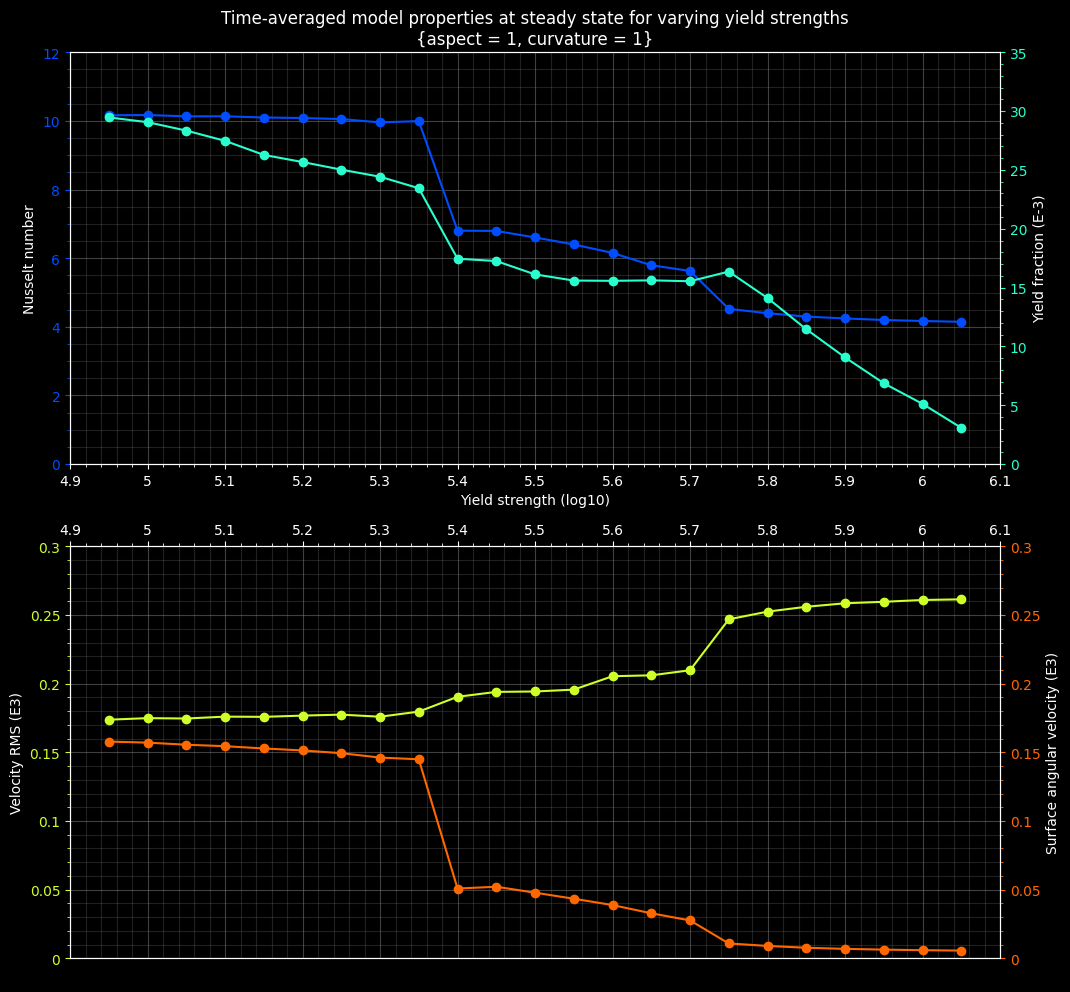

In [75]:
canvas = Canvas(shape = (2, 1), size = (12, 12), facecolour = 'black')
ax1, ax2 = canvas.make_ax(), canvas.make_ax()
ax3, ax4 = canvas.make_ax(place = (1, 0)), canvas.make_ax(place = (1, 0))
allAxs = (ax1, ax2, ax3, ax4)
ax1col = get_cmap('jet')(0.2)
ax2col = get_cmap('jet')(0.4)
ax3col = get_cmap('jet')(0.6)
ax4col = get_cmap('jet')(0.8)
allCols = (ax1col, ax2col, ax3col, ax4col)
x = Data(np.log10(tauRefs), label = 'Yield strength (log10)', lims = (4.9, 6.1), capped = (True, True))
ax1.line(
    x,
    Data(avNus, label = 'Nusselt number', lims = (0, None)),
    c = ax1col,
    marker = 'o',
    )
ax2.line(
    x,
    Data(avYieldFrac, label = 'Yield fraction'),
    c = ax2col,
    marker = 'o',
    )
ax3.line(
    x,
    Data(avVRMS, label = 'Velocity RMS', lims = (0, 300)),
    c = ax3col,
    marker = 'o',
    )
ax4.line(
    x,
    Data(avSurfVel, label = 'Surface angular velocity', lims = (0, 300)),
    c = ax4col,
    marker = 'o',
    )

for ax, axCol in zip(allAxs, allCols):
    ax.axes.colour = 'white'
    ax.ticks.x.colour = 'white'
    ax.ticks.y.colour = axCol
    ax.grid.colour = 'grey'
for ax in (ax2, ax4):
    ax.axes.y.swap()
    ax.grid.visible = False
    ax.axes.x.visible = False
ax3.axes.x.label = ''
ax3.axes.x.swap()
ax1.axes.title = 'Time-averaged model properties at steady state for varying yield strengths\n{aspect = 1, curvature = 1}'

canvas.show()

In [43]:
from IPython.display import Image

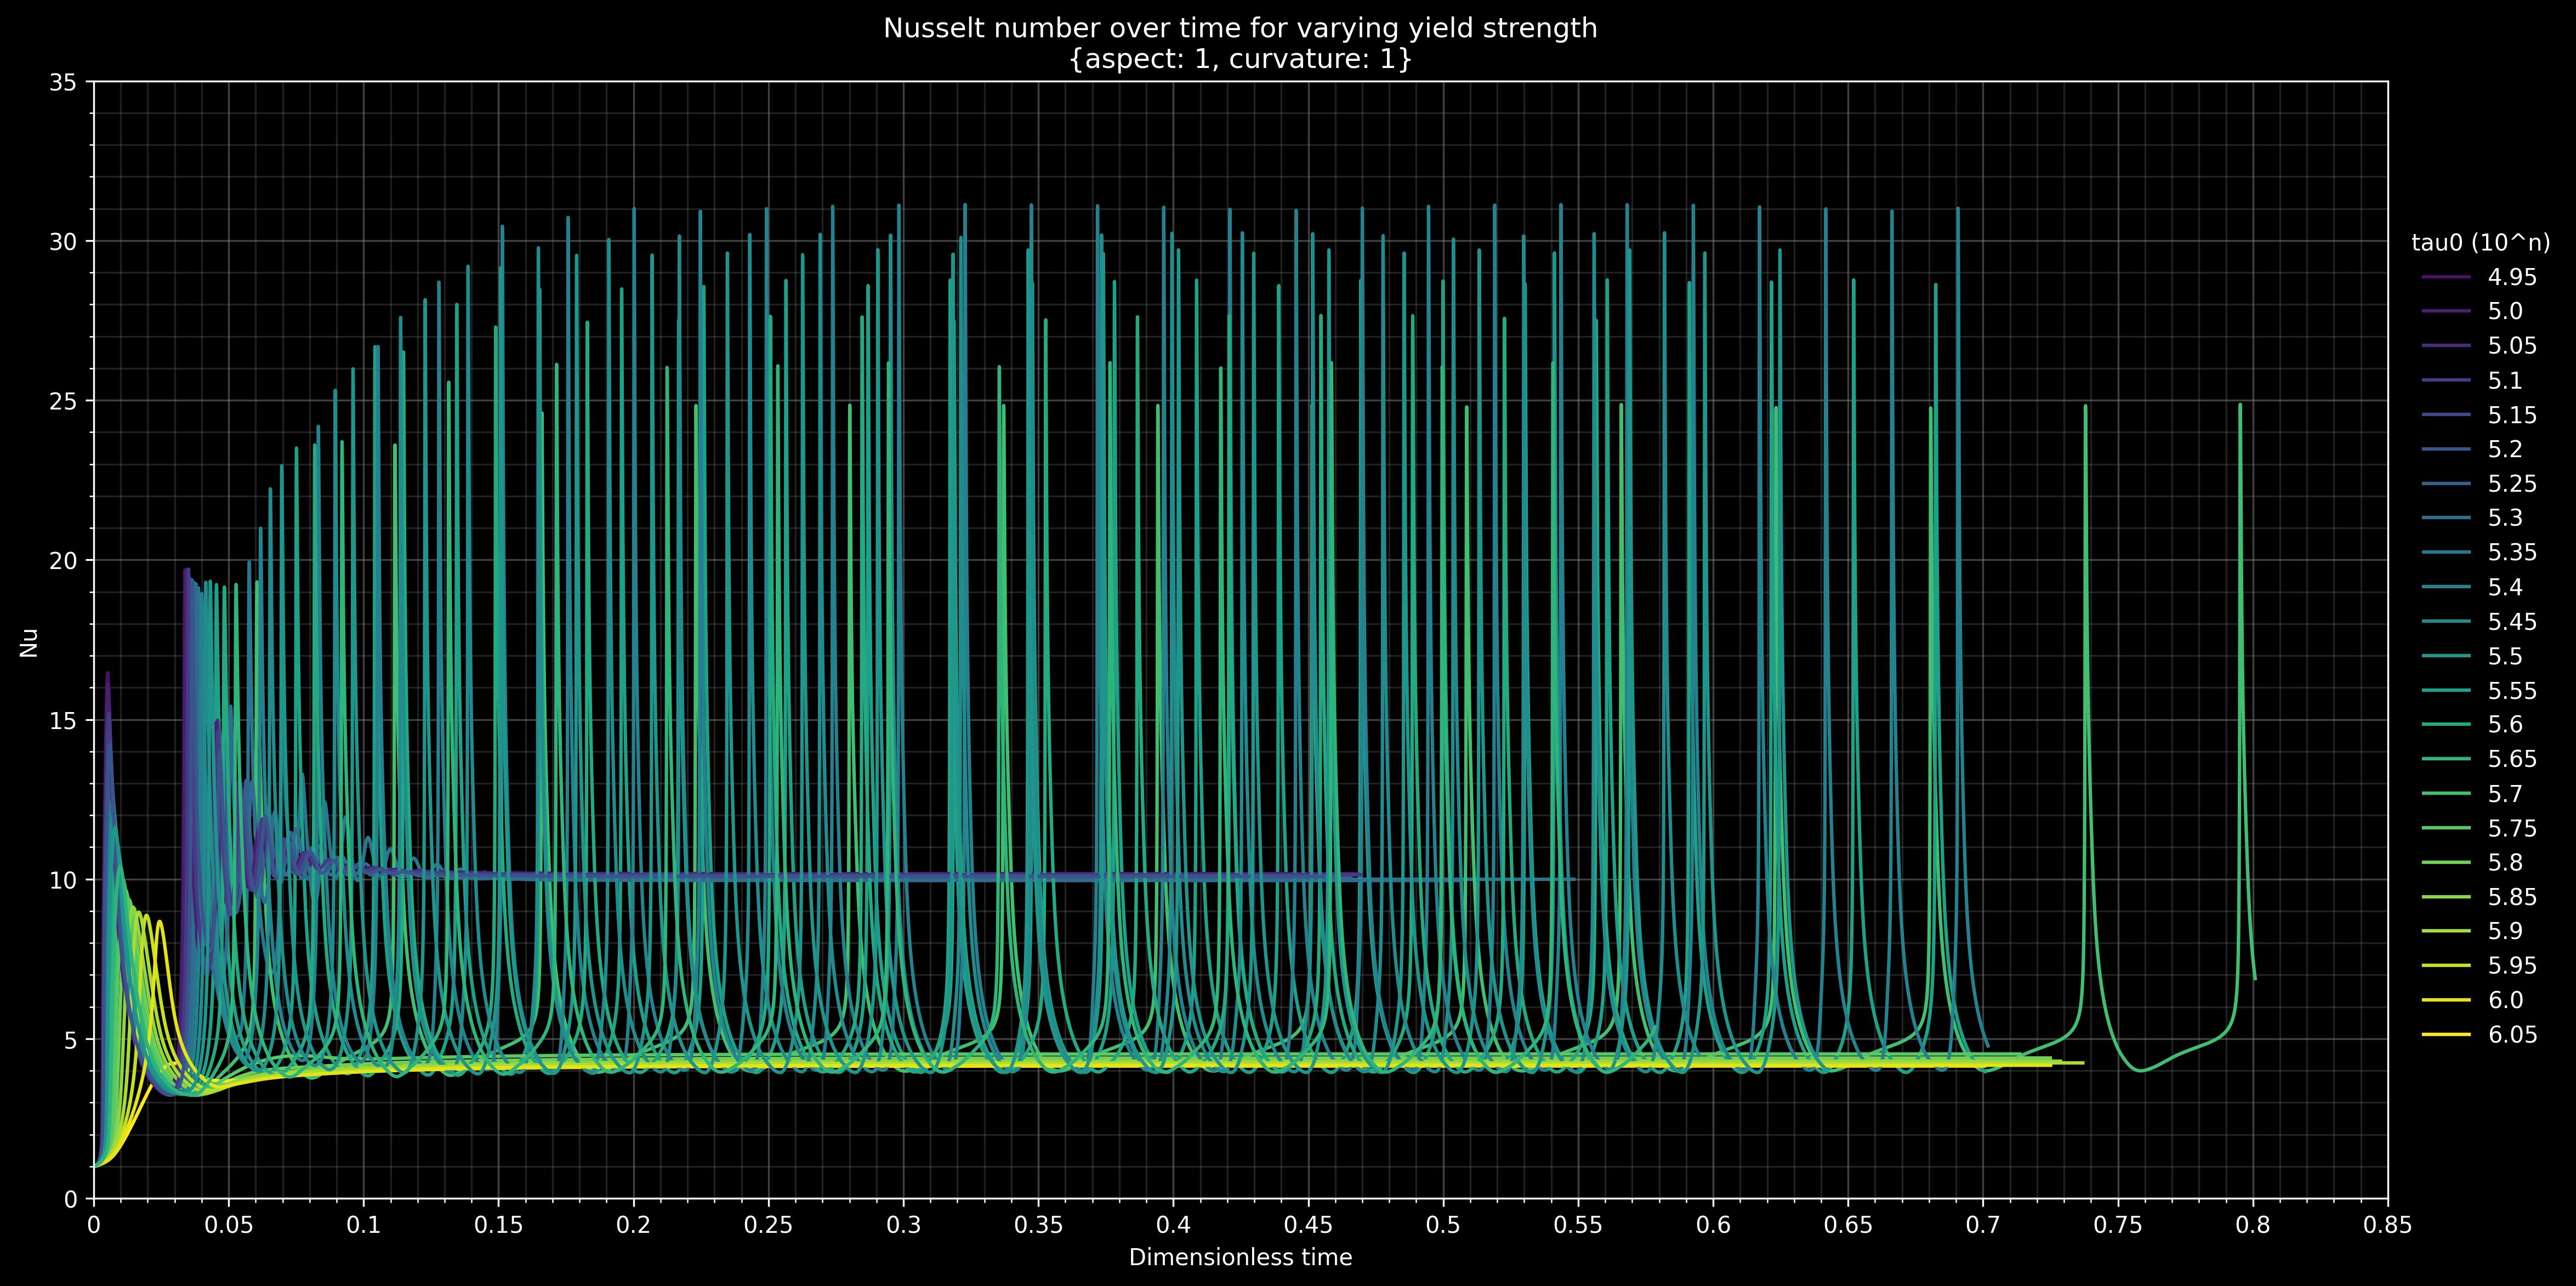

In [45]:
Image('figs/ms98a1f1.png')